<a href="https://colab.research.google.com/github/LSJgobsl/Start_from_zero/blob/master/snp500_20210120.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse

from IPython.display import display
from IPython.display import SVG, Image


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
raw_data = pd.read_csv('./drive/MyDrive/graph/GSPC_5.csv')
raw_data['Date'] = pd.to_datetime(raw_data['Date'])
raw_data.set_index('Date',inplace=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


volume = 주식 거래량 \
open = 장 시작\
close = 장 마감\
high = 장중 최고거래액\
low = 장중 최저거래액

전체 데이터 shape:(1509, 6)


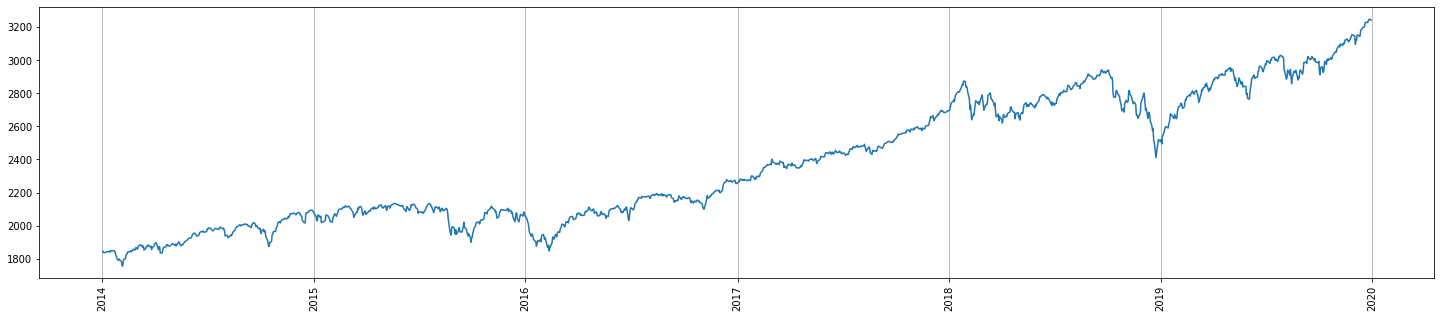

In [4]:
print("전체 데이터 shape:{}".format(raw_data.shape))
plt.figure(figsize=(25,5))
plt.plot(raw_data['High'])
plt.xticks(rotation=90)
plt.grid(axis='x')

In [5]:
output_window = 1
input_window = 250

In [6]:
X_cols = list(raw_data.columns)
X_cols.remove('High')

test_data_size = int(12096*0.3)
X = raw_data[X_cols]
y = raw_data['High']
y.dropna(inplace=True)
print(y)

#scaler_choose = input("1:MinMaxScaler\n2:StandardScaler\n3:None\n")
#scaler_choose = int(scaler_choose)

scaler_choose = 2
if scaler_choose == 1:
  scaler = MinMaxScaler(feature_range=(-1,1))
  y = scaler.fit_transform(y.to_numpy().reshape(-1,1)).reshape(-1)
elif scaler_choose == 2:
  scaler = StandardScaler()
  y = scaler.fit_transform(y.to_numpy().reshape(-1,1)).reshape(-1)
else:
  a=1
#Xscaler = scaler.fit(X)
#yscaler = scaler.fit(y.values.reshape(-1,1))


#X = Xscaler.transform(X)
#y = yscaler.transform(y.values.reshape(-1,1))

#y = scaler.fit_transform(y.to_numpy().reshape(-1,1)).reshape(-1)



X_train, X_test = X[:-test_data_size], X[-test_data_size:]
y_train, y_test = y[:-test_data_size], y[-test_data_size:]

print("train set :",X_train.shape)
print("test set :",X_test.shape)
print("train set : ",(y_train.shape))

#y_train

Date
2014-01-02    1845.859985
2014-01-03    1838.239990
2014-01-06    1837.160034
2014-01-07    1840.099976
2014-01-08    1840.020020
                 ...     
2019-12-23    3227.780029
2019-12-24    3226.429932
2019-12-26    3240.080078
2019-12-27    3247.929932
2019-12-30    3240.919922
Name: High, Length: 1509, dtype: float64
train set : (0, 5)
test set : (1509, 5)
train set :  (0,)


#**seq data 형성함수**
>create sequence 시퀀스를 생성한다 \
 그리고 sequence로 바꾼다.

In [7]:
mdl = input("사용 Model\n 1:Transformer 2:LSTM: ")
mdl = int(mdl)

사용 Model
 1:Transformer 2:LSTM: 1


In [8]:
def create_sequences1(array, tw):
  res = []
  L = len(array)
  for i in range(L - tw ):
    #print(len(array[i:i+tw]))
    tr_seq = array[i:i + tw]
    #print(tr_seq)
    train_label = array[i+output_window:i+output_window + tw]
    res.append((tr_seq, train_label))
  return torch.FloatTensor(res)

In [9]:
#모델 테스트용 데이터
def get_data():
  time = np.arange(0,400,0.1)
  amplitude = np.sin(time) + np.sin(time*0.05) + np.sin(time*0.12)*np.random.normal(-0.2,0.2,len(time))

  scaler_t = MinMaxScaler()
  amplitude = scaler_t.fit_transform(amplitude.reshape(-1,1)).reshape(-1)

  sample = 2800
  sin_train = amplitude[:sample]
  sin_test = amplitude[sample:]

  train_sequence = create_sequences1(sin_train, input_window)
  train_sequence = train_sequence[:-output_window]

  test_data = create_sequences1(sin_test, input_window)
  test_data = test_data[:-output_window]

  return train_sequence.to(device), test_data.to(device)

In [10]:
seq_len = input_window
#X_train = create_sequences1(X_train, seq_len)
y_train_seq = create_sequences1(y_train, seq_len)
#X_test = create_sequences1(X_test, seq_len)
y_test_seq = create_sequences1(y_test, seq_len)

y_train_seq = y_train_seq[:-output_window]
y_test_seq = y_test_seq[:-output_window]
print(y_train_seq.shape)


torch.Size([0])


In [11]:
y_train_seq

tensor([])

>예시


예시의 create_inout_sequences 역할과 비슷

In [12]:
#print("X_train :",(X_train.shape))
#print("X_test :",(X_test.shape))
#print("y_train :",(y_train_seq.shape))
#print("y_test :",(y_test_seq.shape))

**LSTM**

In [13]:
class LSTMmodule(nn.Module):
  def __init__(self, input_size = 1, hidden_layer_size=100, output_size = 1):
    #input_size : 입력값의 feature의 개수
    #hidden_layer_size : 힏ㄴ 레이어(뉴런 개수)
    #output size : 출력 갯수
    super().__init__()
    self.hidden_layer_size = hidden_layer_size

    self.lstm = nn.LSTM(input_size, hidden_layer_size)

    self.linear = nn.Linear(hidden_layer_size, output_size)

    self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                        torch.zeros(1,1,self.hidden_layer_size))

  
  def forward(self, input_seq):
    lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq),1,-1), self.hidden_cell)
    predictions = self.linear(lstm_out.view(len(input_seq),-1))
    return predictions[-1]

    


**MODEL 정의하기**
**Transformer**

In [14]:
class TransformerModel(nn.Module):

  def __init__(self, ninp = 256, nlayers=1, dropout=0.2):
    super(TransformerModel, self).__init__()

    from torch.nn import TransformerEncoder, TransformerEncoderLayer
    
    self.model_type = 'Transformer'
    
    self.src_mask = None
    
    self.ninp = ninp
    self.pos_encoder = PositionalEncoding(ninp)
    self.encoder_layers = TransformerEncoderLayer(d_model = ninp, nhead = 8, dropout = dropout)
    self.transformer_encoder = TransformerEncoder(self.encoder_layers, num_layers = nlayers)
   # self.encoder = nn.Embedding(1, ninp) #시계열에서 불필요?
    self.decoder = nn.Linear(ninp, 1)

    self.init_weights()

  def _generate_square_subsequent_mask(self, sz):
    mask = (torch.triu(torch.ones(sz,sz))==1).transpose(0,1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

  def init_weights(self):
    initrange = 0.1
    #self.encoder.weight.data.uniform_(-initrange,initrange)
    self.decoder.bias.data.zero_()
    self.decoder.weight.data.uniform_(-initrange, initrange)

  def forward(self, src):
    if self.src_mask is None or self.src_mask.size(0) != len(src):
      device = src.device
      mask = self._generate_square_subsequent_mask(len(src)).to(device)
      self.src_mask = mask

    #src = self.encoder(src)*math.sqrt(self.ninp)
    src = self.pos_encoder(src)
    output = self.transformer_encoder(src, self.src_mask)
    output = self.decoder(output)
    return output

**Positional Encoing**


In [15]:
class PositionalEncoding(nn.Module):
  def __init__(self, d_model, dropout = 0.2, max_len=5000):
    super(PositionalEncoding, self).__init__()
    self.dropout = nn.Dropout(p=dropout)


    pe = torch.zeros(max_len, d_model)
    position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0)/d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    pe = pe.unsqueeze(0).transpose(0,1)
    self.register_buffer('pe',pe)
  
  def forward(self,x):
    x = x + self.pe[:x.size(0), :]
    return self.dropout(x)

In [16]:
'''
model = TransformerModel()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
'''

'\nmodel = TransformerModel()\nloss_function = nn.MSELoss()\noptimizer = torch.optim.Adam(model.parameters(), lr=0.001)\n'


**트랜스포머 모델 프린트**
```
# 코드로 형식 지정됨
TransformerModel(
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (encoder_layers): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): _LinearWithBias(in_features=256, out_features=256, bias=True)
    )
    (linear1): Linear(in_features=256, out_features=2048, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (linear2): Linear(in_features=2048, out_features=256, bias=True)
    (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.2, inplace=False)
    (dropout2): Dropout(p=0.2, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=2048, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=2048, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (decoder): Linear(in_features=256, out_features=1, bias=True)
)
```



In [17]:
def get_batch(source, i, batch_size):
  length = min(batch_size, len(source) - 1 - i)
  data = source[i:i+length]
  input = torch.stack(torch.stack([item[0] for item in data]).chunk(input_window,1)) #1은 feature size
  target = torch.stack(torch.stack([item[1] for item in data]).chunk(input_window,1))
  return input, target

#**Train 생성하기**


In [18]:
import os
def createDirectory(directory):
  try:
    if not os.path.exists(directory):
      os.makedirs(directory)
  except OSError:
    print("failed")

In [19]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse

In [20]:

def MPE(test, pred):

  #test, pred = check_array

  return torch.mean((test - pred) / test)*100

In [21]:
def plot_and_loss(eval_model, data_source, epoch):
  eval_model.eval()
  total_loss = 0.
  test_result = torch.Tensor(0)
  truth = torch.Tensor(0)
  with torch.no_grad():
    for i in range(0,len(data_source) - 1):
      daat, target = get_batch(data_source, i, 1)
      output = eval_model(daat)

      total_loss += criterion(output,target).item()


      test_result = torch.cat((test_result, output[-1].view(-1).cpu()), 0)
      truth = torch.cat((truth, target[-1].view(-1).cpu()),0)
    
  print("R^2 score:", r2_score(truth, test_result))
  print("MSE score:", mse(truth, test_result))
  print("RMSE SCORE:",np.sqrt(mse(truth, test_result)))
  print("MPE SCORE:", MPE(truth, test_result))

  len(test_result)
  print(test_result)
  plt.plot(test_result, color = "red")
  plt.plot(truth,color="blue")
  plt.plot(test_result-truth, color="yellow")
  plt.grid(True, which='both')
  plt.axhline(y=0,color='k')
  createDirectory("./drive/MyDrive/graph/Per10")
  plt.savefig("./drive/MyDrive/graph/Per10/transformer-epoch%d.png"%epoch)
  plt.close()

  return total_loss / i

In [22]:

batch_size = 1

def evaluate(eval_model, data_source):
  eval_model.eval()
  total_loss = 0.
  eval_batch_size = 1000
  with torch.no_grad():
    for i in range(0, len(data_source) - 1, eval_batch_size):
      data, targets = get_batch(data_source, i, eval_batch_size)
      output = eval_model(data)
      total_loss += len(data[0])*criterion(output, targets).cpu().item()
  return total_loss/len(data_source)

def predict(eval_model, data_source, steps, epoch):
  eval_model.eval()
  total_loss = 0.
  test_results = torch.Tensor(0)
  truth = torch.Tensor(0)
  _, data = get_batch(data_source, 0,1)

  with torch.no_grad():
    for i in range(0, steps, 1):
      
      input = torch.clone(data[-input_window:])
      input[-output_window:] = 0

      output = eval_model(data[-input_window:])
      data = torch.cat((data, output[-1:]))

  data = data.cpu().view(-1)

  plt.plot(data, color="red")
  plt.plot(data[:input_window],color="blue")
  plt.grid(True, which='both')
  plt.axhline(y=0, color='k')
  plt.savefig('./drive/MyDrive/graph/future/1000transformer-future%d_%d.png'% (steps, epoch ))
  plt.close()


In [23]:
def train(train_data):
  
  model.train() #학습모드 시작
  total_loss = 0. #total loss 초기화
  start_time = time.time() 
  
  for batch, i in enumerate(range(0, len(train_data) - 1,batch_size)):
    
    data, targets = get_batch(train_data, i, batch_size)
    
    optimizer.zero_grad()
    
    output = model(data)
        
    loss = criterion(output, targets)
    
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(),0.7)
    optimizer.step()

    total_loss += loss.item()
    log_interval = int(len(train_data) / batch_size)
    if batch % log_interval == 0 and batch > 0:
      cur_loss = total_loss / log_interval
      elapsed = time.time() - start_time
      print('| epoch {:3d} | {:5d}/{:5d} batches |'
        'lr {:02.6f} | ms/batch {:5.2f} | '
        'loss {:5.5f} '.format
        (epoch, batch, len(train_data) // batch_size, scheduler.get_lr()[0],
        elapsed*1000 / log_interval,
        cur_loss))
      total_loss = 0
      start_time = time.time()

**LSTM training**

In [24]:
def train_lstm(train_data):
  model.train()
  total_loss = 0
  start_time = time.time()

  for batch, i in enumerate(range(0, len(train_data)-1, batch_size)):

    data, label = get_batch(train_data, i , batch_size)
    optimizer.zero_grad()
    model.hidden_cell = (torch.zeros(1,1,model.hidden_layer_size),
                         torch.zeros(1,1,model.hidden_layer_size))
    
    y_pred = model(data)

    single_loss = criterion(y_pred, label)
    single_loss.backward()
    optimizer.step()

In [25]:
model = 0
if mdl is 1:
  model = TransformerModel().to(device)
else:
  model = LSTMmodule().to(device)
if mdl is 1:
  train_data = y_train_seq.to(device)
  val_data = y_test_seq.to(device)
else:
  train_data = y_train_seq
  val_data = y_test_seq
#train_data, val_data = get_data()


criterion = nn.MSELoss()
lr = 0.002 #0.0005가 best
optimizer= torch.optim.AdamW(model.parameters(),lr=lr)
#optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma = 0.99)

best_val_loss = float("inf")
epochs = 300
best_model = None

for epoch in range(1, epochs + 1):

  epoch_start_time = time.time()
  if mdl is 1:
    train(train_data)
    if(epoch % 10 is 0):
      val_loss = plot_and_loss(model, val_data, epoch)
      predict(model, val_data, 50, epoch)
    else:
      val_loss = evaluate(model, val_data)
  
    ppl=0.0
    try:
      ppl = math.exp(val_loss)
    except OverflowError:
      ppl = float('inf')

    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.5f} | valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                          val_loss, ppl))
    print('-' * 89)
    scheduler.step()
  else:
    train_lstm(train_data)

-----------------------------------------------------------------------------------------
| end of epoch   1 | time:  0.52s | valid loss 1.22313 | valid ppl     3.40
-----------------------------------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


-----------------------------------------------------------------------------------------
| end of epoch   2 | time:  0.40s | valid loss 1.22313 | valid ppl     3.40
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   3 | time:  0.40s | valid loss 1.22313 | valid ppl     3.40
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   4 | time:  0.41s | valid loss 1.22313 | valid ppl     3.40
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   5 | time:  0.40s | valid loss 1.22313 | valid ppl     3.40
------------------------------------------------------------------

KeyboardInterrupt: ignored